# The Similarity Renormalization Group

## The Pairing Modeal

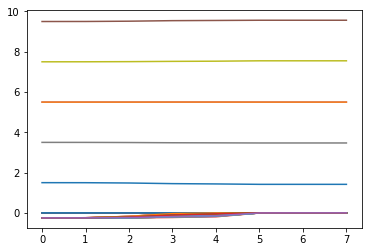

In [23]:
import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint

import matplotlib.pyplot as plt



# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation
def derivative(y, t, dim):
    
    # reshape the solution vector into a dim x dim matrix
    H = reshape(y, (dim,dim))
    
    # extract diagonal Hamiltonian...
    Hd = diag(diag(H))
    
    # ... and construct off-diagonal the Hamiltonian
    Hod = H-Hd
    
    # calculate the generator
    eta = commutator(Hd,Hod)
    
    # dHdt is the derivative in matrix form
    dH = commutator(eta, H)
    
    # convert dH into a linear array for the ODE solver
    dydt = reshape(dH, -1)
    
    return dydt

    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    g = 0.5
    delta = 1
    
    H0 = Hamiltonian(delta,g)
    dim = H0.shape[0]
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(H0, -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.001,0.01,0.05,0.1,1.,5.,10.])
    
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices
    Hs = reshape(ys,(-1,dim,dim))
    
    plt.plot(ys)
    
main()

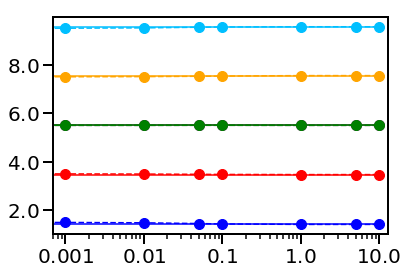

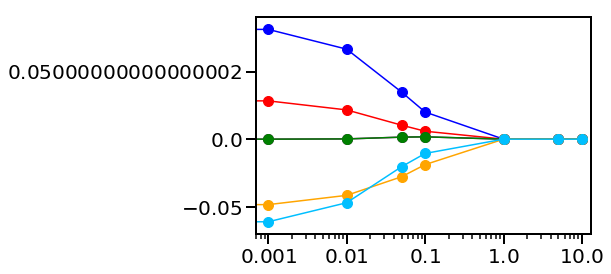

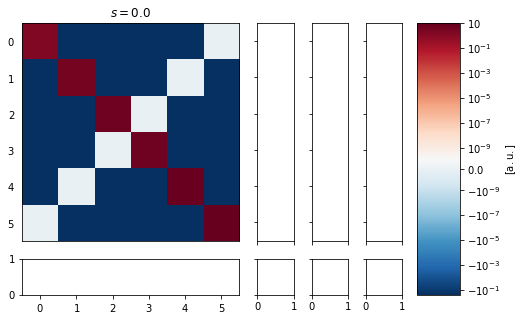

In [26]:
#!/usr/bin/env python

#------------------------------------------------------------------------------
# srg_pairing.py
#
# author:   H. Hergert 
# version:  1.1.0
# date:     Nov 18, 2016
# 
# tested with Python v2.7
# 
# Solves the pairing model for four particles in a basis of four doubly 
# degenerate states by means of a Similarity Renormalization Group (SRG)
# flow.
#
#------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import SymLogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint

#------------------------------------------------------------------------------
# plot helpers
#------------------------------------------------------------------------------
def myLabels(x, pos):
    '''format tick labels using LaTeX-like math fonts'''
    return '$%s$'%x

def myPlotSettings(ax, formatter):
    '''save these settings for use in other plots'''
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='both',which='major',width=1.5,length=8)
    ax.tick_params(axis='both',which='minor',width=1.5,length=5)
    ax.tick_params(axis='both',width=2,length=10,labelsize=20)
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_linewidth(2)
    ax.set_xlim([0.0007,13])  
    return

#------------------------------------------------------------------------------
# plot routines
#------------------------------------------------------------------------------
def plot_diagonals(data, eigenvalues, flowparams, delta, g):
    '''plot eigenvalues and diagonals'''
    dim       = len(data)
    formatter = FuncFormatter(myLabels)
    markers   = ['o' for i in range(dim)]
    cols      = ['blue', 'red', 'purple', 'green', 'orange', 'deepskyblue']

    # diagonals vs. eigenvalues on absolute scale
    fig, ax = plt.subplots()
    for i in range(dim):
        plt.semilogx(flowparams, [eigenvalues[i] for e in range(flowparams.shape[0])], color=cols[i], linestyle='solid')
        plt.semilogx(flowparams, data[i], color=cols[i], linestyle='dashed', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # difference between diagonals and eigenvalues
    fig, ax = plt.subplots()
    for i in range(dim):
        plot_diff = plt.semilogx(flowparams, data[i]-eigenvalues[i], color=cols[i], linestyle='solid', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag-eval_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()
    return

#------------------------------------------------------------------------------
# plot matrix snapshots
#------------------------------------------------------------------------------
def plot_snapshots(Hs, flowparams, delta, g):
    fig  = plt.figure(1, (10., 5.))
    grid = AxesGrid(fig, 111,                       # similar to subplot(111)
                     nrows_ncols=(2, Hs.shape[0]/2),  # creates grid of axes
                     axes_pad=0.25,                 # pad between axes in inch.
                     label_mode='L',                # put labels on left, bottom
                     cbar_mode='single',            # one color bar (default: right of last image in grid)
                     cbar_pad=0.20,                 # insert space between plots and color bar
                     cbar_size='10%'                # size of colorbar relative to last image
                     )

    # create individual snapshots - figures are still addressed by single index,
    # despite multi-row grid
    for s in range(Hs.shape[0]):
        img = grid[s].imshow(Hs[s], 
                            cmap=plt.get_cmap('RdBu_r'),                                  # choose color map
                            interpolation='nearest',       
                            norm=SymLogNorm(linthresh=1e-10,vmin=-0.5*g,vmax=10*delta),   # normalize 
                            vmin=-0.5*g,                                                  # min/max values for data
                            vmax=10*delta
                            )

        # tune plots: switch off tick marks, ensure that plots retain aspect ratio
        grid[s].set_title('$s=%s$'%flowparams[s])
        grid[s].tick_params(      
  
        bottom='off',      
        top='off',
        left='off',      
        right='off'
        )
  
        grid[s].set_xticks([0,1,2,3,4,5])
        grid[s].set_yticks([0,1,2,3,4,5])
        grid[s].set_xticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])
        grid[s].set_yticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])

        cbar = grid.cbar_axes[0]
        plt.colorbar(img, cax=cbar, 
          ticks=[ -1.0e-1, -1.0e-3, -1.0e-5, -1.0e-7, -1.09e-9 , 0., 
                 1.0e-9, 1.0e-7, 1.0e-5, 1.0e-3, 0.1, 10.0]
        )

        cbar.axes.set_yticklabels(['$-10^{-1}$', '$-10^{-3}$', '$-10^{-5}$', '$-10^{-7}$', 
                             '$-10^{-9}$', '$0.0$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', 
                             '$10^{-3}$', '$10^{-1}$', '$10$'])
        cbar.set_ylabel('$\mathrm{[a. u.]}$') 


        plt.savefig("srg_pairing_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
        plt.show()
        
        return



# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation
def derivative(y, t, dim):
    
    # reshape the solution vector into a dim x dim matrix
    H = reshape(y, (dim,dim))
    
    # extract diagonal Hamiltonian...
    Hd = diag(diag(H))
    
    # ... and construct off-diagonal the Hamiltonian
    Hod = H-Hd
    
    # calculate the generator
    eta = commutator(Hd,Hod)
    
    # dHdt is the derivative in matrix form
    dH = commutator(eta, H)
    
    # convert dH into a linear array for the ODE solver
    dydt = reshape(dH, -1)
    
    return dydt

    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    g = 0.5
    delta = 1
    
    H0 = Hamiltonian(delta,g)
    dim = H0.shape[0]
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(H0, -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.001,0.01,0.05,0.1,1.,5.,10.])
    
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices
    Hs = reshape(ys,(-1,dim,dim))
    
    data = []
    for h in Hs:
        data.append(diag(h))
    data = zip(*data)

    plot_diagonals(data, eigenvalues, flowparams, delta, g)
    plot_snapshots(Hs, flowparams, delta, g)

#------------------------------------------------------------------------------
# make executable
#------------------------------------------------------------------------------
if __name__ == "__main__": 
    main()

In [28]:
from scipy.integrate import odeint
odeint?

**LSODA, written jointly with L. R. Petzold, solves systems dy/dt = f with a dense or banded Jacobian when the problem is stiff, but it automatically selects between nonstiff (Adams) and stiff (BDF) methods. It uses the nonstiff method initially, and dynamically monitors data in order to decide which method to use.**

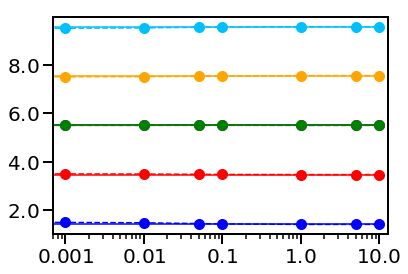

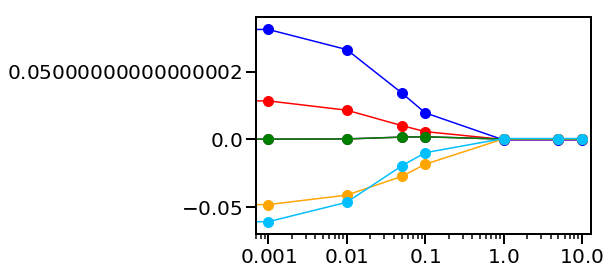

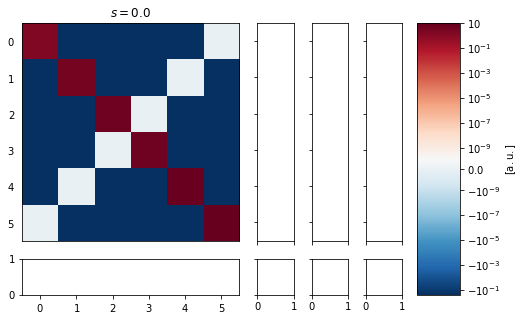

In [81]:
#!/usr/bin/env python

#------------------------------------------------------------------------------
# srg_pairing.py
#
# author:   H. Hergert 
# version:  1.1.0
# date:     Nov 18, 2016
# 
# tested with Python v2.7
# 
# Solves the pairing model for four particles in a basis of four doubly 
# degenerate states by means of a Similarity Renormalization Group (SRG)
# flow.
#
#------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import SymLogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import numpy as np
from numpy import array, dot, diag, reshape
from scipy.linalg import eigvalsh
from scipy.integrate import odeint

#------------------------------------------------------------------------------
# plot helpers
#------------------------------------------------------------------------------
def myLabels(x, pos):
    '''format tick labels using LaTeX-like math fonts'''
    return '$%s$'%x

def myPlotSettings(ax, formatter):
    '''save these settings for use in other plots'''
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='both',which='major',width=1.5,length=8)
    ax.tick_params(axis='both',which='minor',width=1.5,length=5)
    ax.tick_params(axis='both',width=2,length=10,labelsize=20)
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_linewidth(2)
    ax.set_xlim([0.0007,13])  
    return

#------------------------------------------------------------------------------
# plot routines
#------------------------------------------------------------------------------
def plot_diagonals(data, eigenvalues, flowparams, delta, g):
    '''plot eigenvalues and diagonals'''
    dim       = len(data)
    formatter = FuncFormatter(myLabels)
    markers   = ['o' for i in range(dim)]
    cols      = ['blue', 'red', 'purple', 'green', 'orange', 'deepskyblue']

    # diagonals vs. eigenvalues on absolute scale
    fig, ax = plt.subplots()
    for i in range(dim):
        plt.semilogx(flowparams, [eigenvalues[i] for e in range(flowparams.shape[0])], color=cols[i], linestyle='solid')
        plt.semilogx(flowparams, data[i], color=cols[i], linestyle='dashed', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # difference between diagonals and eigenvalues
    fig, ax = plt.subplots()
    for i in range(dim):
        plot_diff = plt.semilogx(flowparams, data[i]-eigenvalues[i], color=cols[i], linestyle='solid', marker=markers[i], markersize=10)

    myPlotSettings(ax, formatter)

    plt.savefig("srg_pairing_diag-eval_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
    plt.show()
    return

#------------------------------------------------------------------------------
# plot matrix snapshots
#------------------------------------------------------------------------------
def plot_snapshots(Hs, flowparams, delta, g):
    fig  = plt.figure(1, (10., 5.))
    grid = AxesGrid(fig, 111,                       # similar to subplot(111)
                     nrows_ncols=(2, Hs.shape[0]/2),  # creates grid of axes
                     axes_pad=0.25,                 # pad between axes in inch.
                     label_mode='L',                # put labels on left, bottom
                     cbar_mode='single',            # one color bar (default: right of last image in grid)
                     cbar_pad=0.20,                 # insert space between plots and color bar
                     cbar_size='10%'                # size of colorbar relative to last image
                     )

    # create individual snapshots - figures are still addressed by single index,
    # despite multi-row grid
    for s in range(Hs.shape[0]):
        img = grid[s].imshow(Hs[s], 
                            cmap=plt.get_cmap('RdBu_r'),                                  # choose color map
                            interpolation='nearest',       
                            norm=SymLogNorm(linthresh=1e-10,vmin=-0.5*g,vmax=10*delta),   # normalize 
                            vmin=-0.5*g,                                                  # min/max values for data
                            vmax=10*delta
                            )

        # tune plots: switch off tick marks, ensure that plots retain aspect ratio
        grid[s].set_title('$s=%s$'%flowparams[s])
        grid[s].tick_params(      
  
        bottom='off',      
        top='off',
        left='off',      
        right='off'
        )
  
        grid[s].set_xticks([0,1,2,3,4,5])
        grid[s].set_yticks([0,1,2,3,4,5])
        grid[s].set_xticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])
        grid[s].set_yticklabels(['$0$','$1$','$2$','$3$','$4$','$5$'])

        cbar = grid.cbar_axes[0]
        plt.colorbar(img, cax=cbar, 
          ticks=[ -1.0e-1, -1.0e-3, -1.0e-5, -1.0e-7, -1.09e-9 , 0., 
                 1.0e-9, 1.0e-7, 1.0e-5, 1.0e-3, 0.1, 10.0]
        )

        cbar.axes.set_yticklabels(['$-10^{-1}$', '$-10^{-3}$', '$-10^{-5}$', '$-10^{-7}$', 
                             '$-10^{-9}$', '$0.0$', '$10^{-9}$', '$10^{-7}$', '$10^{-5}$', 
                             '$10^{-3}$', '$10^{-1}$', '$10$'])
        cbar.set_ylabel('$\mathrm{[a. u.]}$') 


        plt.savefig("srg_pairing_delta%2.1f_g%2.1f.pdf"%(delta, g), bbox_inches="tight", pad_inches=0.05)
        plt.show()
        
        return



# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation
def derivative(y, dim):
    
    # reshape the solution vector into a dim x dim matrix
    H = reshape(y, (dim,dim))
    
    # extract diagonal Hamiltonian...
    Hd = diag(diag(H))
    
    # ... and construct off-diagonal the Hamiltonian
    Hod = H-Hd
    
    # calculate the generator
    eta = commutator(Hd,Hod)
    
    # dHdt is the derivative in matrix form
    dH = commutator(eta, H)
    
    # convert dH into a linear array for the ODE solver
    dydt = reshape(dH, -1)
    
    return dydt

    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    g = 0.5
    delta = 1
    
    H0 = Hamiltonian(delta,g)
    dim = H0.shape[0]
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(H0, -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.001,0.01,0.05,0.1,1.,5.,10.])
    
    ds = 0.001
    ys = y0
    ys_list = [y0]
    
    for i in range(10000):
        
        ys = ys + derivative(ys, dim)*ds
        
        if i == 0:
            ys_list.append(ys)
            
        if i == 9:
            ys_list.append(ys)
            
        if i == 49:
            ys_list.append(ys)
        
        if i == 99:
            ys_list.append(ys)
        
        if i == 999:
            ys_list.append(ys)
            
        if i == 4999:
            ys_list.append(ys)
            
        if i == 9999:
            ys_list.append(ys)
    
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    # ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices
    Hs = reshape(ys_list,(-1,dim,dim))
    
    data = []
    for h in Hs:
        data.append(diag(h))
    data = zip(*data)

    plot_diagonals(data, eigenvalues, flowparams, delta, g)
    plot_snapshots(Hs, flowparams, delta, g)

#------------------------------------------------------------------------------
# make executable
#------------------------------------------------------------------------------
if __name__ == "__main__": 
    main()

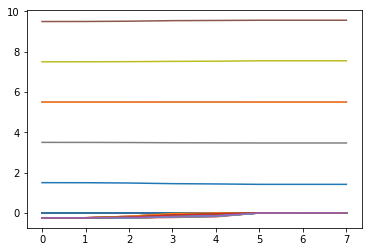

In [77]:
# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation
def derivative(y, dim):
    
    # reshape the solution vector into a dim x dim matrix
    H = reshape(y, (dim,dim))
    
    # extract diagonal Hamiltonian...
    Hd = diag(diag(H))
    
    # ... and construct off-diagonal the Hamiltonian
    Hod = H-Hd
    
    # calculate the generator
    eta = commutator(Hd,Hod)
    
    # dHdt is the derivative in matrix form
    dH = commutator(eta, H)
    
    # convert dH into a linear array for the ODE solver
    dydt = reshape(dH, -1)
    
    return dydt

    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    g = 0.5
    delta = 1
    
    H0 = Hamiltonian(delta,g)
    dim = H0.shape[0]
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(H0, -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.001,0.01,0.05,0.1,1.,5.,10.])
    
    ds = 0.001
    ys = y0
    ys_list = [y0]
    
    for i in range(10000):
        
        ys = ys + derivative(ys, dim)*ds
        
        if i == 0:
            ys_list.append(ys)
            
        if i == 9:
            ys_list.append(ys)
            
        if i == 49:
            ys_list.append(ys)
        
        if i == 99:
            ys_list.append(ys)
        
        if i == 999:
            ys_list.append(ys)
            
        if i == 4999:
            ys_list.append(ys)
            
        if i == 9999:
            ys_list.append(ys)
    
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    # ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices
    Hs = reshape(ys_list,(-1,dim,dim))
    
    plt.plot(ys_list)

main()

[1.41677428 3.47067322 5.5        5.5        7.54943676 9.56311574]


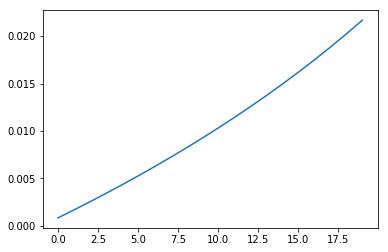

In [113]:
from numpy import linalg as LA

# Hamiltonian for the pairing model
def Hamiltonian(delta,g):
    
    H = array(
        [[2*delta-g, -0.5*g, -0.5*g, -0.5*g, -0.5*g, 0.],
         [-0.5*g, 4*delta-g, -0.5*g, -0.5*g, 0., -0.5*g],
         [-0.5*g, -0.5*g, 6*delta-g, 0., -0.5*g, -0.5*g],
         [-0.5*g, -0.5*g, 0., 6*delta-g, -0.5*g, -0.5*g],
         [-0.5*g, 0., -0.5*g, -0.5*g, 8*delta-g, -0.5*g],
         [0., -0.5*g, -0.5*g, -0.5*g, -0.5*g, 10*delta-g]])
    
    return H

# commutator of matrices
def commutator(a,b):
    
    return dot(a,b) - dot(b,a)

# right-hand side of the flow equation
def derivative(y, dim):
    
    # reshape the solution vector into a dim x dim matrix
    H = reshape(y, (dim,dim))
    
    # extract diagonal Hamiltonian...
    Hd = diag(diag(H))
    
    # ... and construct off-diagonal the Hamiltonian
    Hod = H-Hd
    
    # calculate the generator
    eta = commutator(Hd,Hod)
    
    # dHdt is the derivative in matrix form
    dH = commutator(eta, H)
    
    # convert dH into a linear array for the ODE solver
    dydt = reshape(dH, -1)
    
    return dydt

    

#-------------------------------------
# Main program
#-------------------------------------
def main():
    g = 0.5
    delta = 1
    
    H0 = Hamiltonian(delta,g)
    dim = H0.shape[0]
    
    #calculate exact eigenvalues
    eigenvalues = eigvalsh(H0)
    
    print(eigenvalues)
    
    # turn initial Hamiltonian into a linear array
    y0 = reshape(H0, -1)
    
    # flow parameters for snapshot images
    flowparams = array([0.,0.001,0.01,0.05,0.1,1.,5.,10.])
    
    error_list = []
    
    for n in range(20):
        
        ys = y0
        
        ds = 0.001*(n+1)
        
        for i in range(int(10/ds)):
            
            ys = ys + derivative(ys, dim)*ds
            
            if i == int(10/ds) - 1:
                
                Hs = reshape(ys, (dim,dim))
                
                eigenvalues_Hs = eigvalsh(Hs)
                
                error_list.append(LA.norm(eigenvalues-eigenvalues_Hs,2))
    
    plt.plot(error_list)
                
    # integrate flow eqautions - odeint returns an array of solutions, which are 1d arrays themselves
    # ys = odeint(derivative, y0, flowparams, args=(dim,))
    
    # reshape individual solution vectors into dim x dim Hamiltonian matrices


main()